In [1]:
import numpy as np
import pandas as pd
import os

from sklearn import preprocessing as pre

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, LeakyReLU, Flatten
import time

from tensorflow.keras.layers import Lambda

from tensorflow.keras.layers import Input, Dense, ConvLSTM1D, BatchNormalization, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model

# Ploting
import matplotlib.pyplot as plt

In [2]:
data_path='/kaggle/input/prices-split-adjusted/prices-split-adjusted.csv'
dataframe = pd.read_csv(data_path, delimiter=',')

NSEI_data_path='/kaggle/input/lstm-gan-datasets/NSEI.csv'
NSEI_dataframe = pd.read_csv(NSEI_data_path, delimiter=',')

In [3]:
NSEI_dataframe = NSEI_dataframe.iloc[1400:] #2957
NSEI_dataframe = NSEI_dataframe.drop(NSEI_dataframe.columns[5], axis=1)

In [4]:
dataframe #2957

,date,symbol,open,close,low,high,volume
0,2011-01-03,ADANIENT.NS,100.40,83.20,98.86,101.13,877846
1,2011-01-04,ADANIENT.NS,99.63,83.40,99.06,100.55,1187179
2,2011-01-05,ADANIENT.NS,98.86,83.62,98.32,101.13,1453648
3,2011-01-06,ADANIENT.NS,100.56,82.64,95.05,103.43,45665126
4,2011-01-07,ADANIENT.NS,99.13,80.55,95.51,100.55,1698984
...,...,...,...,...,...,...,...
141534,2022-12-26,WIPRO.NS,378.00,379.57,376.30,381.60,3630574
141535,2022-12-27,WIPRO.NS,382.50,385.65,380.25,387.35,3842920
141536,2022-12-28,WIPRO.NS,385.00,386.85,383.25,389.55,3838001
141537,2022-12-29,WIPRO.NS,386.25,389.79,384.80,392.10,4742699


In [5]:
stocks = ['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS',
       'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS',
       'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS',
       'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS',
       'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS',
       'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS',
       'ITC.NS', 'INDUSINDBK.NS', 'INFY.NS', 'JSWSTEEL.NS',
       'KOTAKBANK.NS', 'LT.NS', 'M&M.NS', 'MARUTI.NS', 'NTPC.NS',
       'NESTLEIND.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS',
       'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TCS.NS', 'TATACONSUM.NS',
       'TATAMOTORS.NS', 'TATASTEEL.NS', 'TECHM.NS', 'TITAN.NS', 'UPL.NS',
       'ULTRACEMCO.NS', 'WIPRO.NS']

In [6]:
def read_data_of_a_stock(dataset, name_of_stock):
    # taking the column of dataset having the name of stocks:
    names_of_stocks = dataset[:, 1]
    # find the indices of a specific stock:
    stock_index = np.where(names_of_stocks == name_of_stock)
    dataset_selected_stock = dataset[stock_index[0], :]
    return dataset_selected_stock

In [7]:
data = dataframe.values
dataframe_train = pd.DataFrame()
dataframe_test = pd.DataFrame()
for stock in stocks:
    stock_data = read_data_of_a_stock(data, stock)
    n_samples = stock_data.shape[0]
    split = int(n_samples * 0.8)
    stock_dataframe = pd.DataFrame(stock_data)
    stock_dataframe[2] = (stock_dataframe[2] - stock_dataframe[2].mean()) / stock_dataframe[2].std()
    stock_dataframe[3] = (stock_dataframe[3] - stock_dataframe[3].mean()) / stock_dataframe[3].std()
    stock_dataframe[4] = (stock_dataframe[4] - stock_dataframe[4].mean()) / stock_dataframe[4].std()
    stock_dataframe[5] = (stock_dataframe[5] - stock_dataframe[5].mean()) / stock_dataframe[5].std()
    stock_dataframe[6] = (stock_dataframe[6] - stock_dataframe[6].mean()) / stock_dataframe[6].std()
    stock_training = stock_dataframe.iloc[:split]
    stock_testing = stock_dataframe.iloc[split:]
    dataframe_train = pd.concat([dataframe_train, stock_training])
    dataframe_test = pd.concat([dataframe_test, stock_testing])

In [8]:
NSEI_data = NSEI_dataframe.values
NSEI_dataframe = pd.DataFrame(NSEI_data)

In [9]:

NSEI_dataframe[1] = (NSEI_dataframe[1] - NSEI_dataframe[1].mean()) / NSEI_dataframe[1].std()
NSEI_dataframe[2] = (NSEI_dataframe[2] - NSEI_dataframe[2].mean()) / NSEI_dataframe[2].std()
NSEI_dataframe[3] = (NSEI_dataframe[3] - NSEI_dataframe[3].mean()) / NSEI_dataframe[3].std()
NSEI_dataframe[4] = (NSEI_dataframe[4] - NSEI_dataframe[4].mean()) / NSEI_dataframe[4].std()
NSEI_dataframe[5] = (NSEI_dataframe[5] - NSEI_dataframe[5].mean()) / NSEI_dataframe[5].std()

NSEI_data=NSEI_dataframe.drop(NSEI_dataframe.columns[0], axis=1).to_numpy()
NSEI_data = np.float64(NSEI_data)
n_nsei = NSEI_data.shape[0]

In [10]:
class Standarized_TimeseriesGenerator(tf.keras.preprocessing.sequence.TimeseriesGenerator):
    def __getitem__(self, index):
        samples, targets  = super(Standarized_TimeseriesGenerator, self).__getitem__(index)
        # shape : (n_batch, n_sequence, n_features)
        mean = samples.mean(axis=1)
        std = samples.std(axis=1)
        samples = (samples - mean[:,None,:])/std[:,None,:] #standarize along each feature
        #targets = (targets - mean[..., 3])/std[..., 3] # The close value is our target
        targets = (targets - mean)/std # The close value is our target
        return samples, targets

In [11]:
dataframe_train=dataframe_train.drop(dataframe_train.columns[1], axis=1)
dataframe_test=dataframe_test.drop(dataframe_test.columns[1], axis=1)

In [12]:
data_train=dataframe_train.drop(dataframe_train.columns[0], axis=1).to_numpy()
data_test=dataframe_test.drop(dataframe_test.columns[0], axis=1).to_numpy()
data_train = np.float64(data_train)
data_test = np.float64(data_test)

In [13]:
n_train = data_train.shape[0]
n_test = data_test.shape[0]

In [14]:
n_sequence = 5 #5 days input
n_features = 5 #7 
n_batch = 32

targets_train = data_train
targets_test = data_test
data_gen_train = Standarized_TimeseriesGenerator(data_train, targets_train,
                                    length=n_sequence, sampling_rate=1,
                                    stride=1, batch_size=n_batch,
                                    start_index = 0,
                                    end_index = n_train-1)
data_gen_test = Standarized_TimeseriesGenerator(data_test,targets_test,
                                    length=n_sequence, sampling_rate=1,
                                    stride=1, batch_size=n_batch,
                                    start_index = 0,
                                    end_index = n_test-1)

data

In [15]:
def mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3]))
def mae(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:,3]-y_pred[:,3])))
def ar(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(x, y, fake_output):
    a1=0.01
    g_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)
    g_mse = tf.keras.losses.MSE(x, y)
    return a1*g_mse + (1-a1)*g_loss, g_mse

In [17]:
def make_conv_generator_model():
  
    trailer_input  = Input(shape=(n_sequence, n_features,1))
    first_ConvLSTM = ConvLSTM1D(filters=64, kernel_size=8
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same', return_sequences=True)(trailer_input)
    first_BatchNormalization = BatchNormalization()(first_ConvLSTM)
    conv_1_1_first = Conv2D(32, (1,1), activation='relu')(first_BatchNormalization)
    conv_1_1_second = Conv2D(16, (1,1), activation='relu')(conv_1_1_first)
    conv_1_1_third = Conv2D(8, (1,1), activation='relu')(conv_1_1_second)
    first_Pooling = GlobalAveragePooling2D(data_format='channels_last')(conv_1_1_third)
    lstm_1_droput = Dropout(0.3)(first_Pooling)
    output_dense = Dense(n_features, activation=None)(lstm_1_droput)
    output = LeakyReLU(alpha=0.3)(output_dense) 
    model = Model(inputs=trailer_input, outputs=output)
    model.compile(loss=None, metrics = [mse , mae, mape, rmse, ar])
    model.summary()
    
    return model

In [18]:
generator = make_conv_generator_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 5, 1)]         0         
                                                                 
 conv_lstm1d (ConvLSTM1D)    (None, 5, 5, 64)          133376    
                                                                 
 batch_normalization (Batch  (None, 5, 5, 64)          256       
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          2080      
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          528       
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 8)           136       
                                                             

In [19]:
def make_discriminator_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(units=72, input_shape=((n_sequence+1) * n_features,), activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(tf.keras.layers.GaussianNoise(stddev=0.2))
    model.add(Dropout(0.3))
    model.add(Dense(units=100, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(units=10, activation=None, kernel_initializer='random_normal'))
    model.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    model.add(Dropout(0.3))
    model.add(Dense(1 ,activation='sigmoid'))
    model.compile(loss=discriminator_loss)
    #history = model.fit(data_gen_train, validation_data=data_gen_test, epochs = 100, 
    #                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5))
    
    return model

In [20]:
discriminator=make_discriminator_model()

In [21]:
learning_rate=1e-4 #lower for transfer learning 
generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.5)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
EPOCHS=30

In [24]:
def train_step_def(sequences, sequences_end):
  # sequences is the real output

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_prediction = generator(sequences, training=True)

        sequences_true = tf.concat((sequences, sequences_end[:, None, :]), axis=1)
        sequences_fake = tf.concat((sequences, generated_prediction[:, None, :]), axis=1)

        real_output = discriminator(sequences_true, training=True)
        fake_output = discriminator(sequences_fake, training=True)

        gen_loss, gen_mse_loss = generator_loss(generated_prediction, 
                                            sequences_end, 
                                            fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

def test_step_def(sequences, sequences_end):
    generated_prediction = generator(sequences, training=False)

    sequences_true = tf.concat((sequences, sequences_end[:,None,:]), axis=1)
    sequences_fake = tf.concat((sequences, generated_prediction[:,None,:]), axis=1)

    real_output = discriminator(sequences_true, training=False)
    fake_output = discriminator(sequences_fake, training=False)

    gen_loss, gen_mse_loss = generator_loss(generated_prediction, sequences_end, fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    return tf.reduce_mean(gen_loss), tf.reduce_mean(disc_loss), tf.reduce_mean(gen_mse_loss)

In [25]:
@tf.function
def train_step(sequences, sequences_end):
    return train_step_def(sequences, sequences_end)

In [26]:
@tf.function
def test_step(sequences, sequences_end):
    return test_step_def(sequences, sequences_end)

In [27]:
def train(dataset, dataset_val, epochs):
    history = np.empty(shape = (8, epochs))
    history_val = np.empty(shape = (8, epochs))
    len_dataset = len(dataset)
    len_dataset_val = len(dataset_val)
    for epoch in range(epochs):
        start = time.time()

        cur_dis_loss = 0
        cur_gen_loss = 0
        cur_gen_mse_loss = 0
        for sequence_batch, sequence_end_batch in dataset:
            aux_cur_losses = train_step(tf.cast(sequence_batch, tf.float32), 
                                          tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss += aux_cur_losses[0]/len_dataset
            cur_dis_loss += aux_cur_losses[1]/len_dataset
            cur_gen_mse_loss += aux_cur_losses[2]/len_dataset

        #cur_gen_loss = generator.evaluate(dataset,verbose=False)
        cur_gen_metrics = generator.evaluate(dataset,verbose=False)[1:]
        #cur_dis_loss = discriminator.evaluate(dataset,verbose=False)

        history[:, epoch] = cur_gen_loss, cur_dis_loss, cur_gen_mse_loss, *cur_gen_metrics
        #history[:, epoch] = cur_gen_loss, *cur_gen_slice_metrics

        #cur_gen_loss_val = generator.evaluate(dataset_val,verbose=False)
        cur_gen_metrics_val = generator.evaluate(dataset_val,verbose=False)[1: ]

        #cur_dis_loss_val = discriminator.evaluate(dataset_val,verbose=False)

        cur_gen_loss_val = 0
        cur_dis_loss_val = 0
        cur_gen_mse_loss_val = 0
        for sequence_batch, sequence_end_batch in dataset_val:
            aux_cur_losses_val = test_step(tf.cast(sequence_batch, tf.float32), 
                                         tf.cast(sequence_end_batch, tf.float32))
            cur_gen_loss_val += aux_cur_losses_val[0]/len_dataset_val
            cur_dis_loss_val += aux_cur_losses_val[1]/len_dataset_val
            cur_gen_mse_loss_val += aux_cur_losses_val[2]/len_dataset_val

        history_val[:, epoch] = cur_gen_loss_val, cur_dis_loss_val, cur_gen_mse_loss_val, *cur_gen_metrics_val


         # Save the model every 10 epochs
        if (epoch + 1) % 1 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            print ('Time for epoch {} is {} sec Generator Loss: {},  Discriminator_loss: {}'
               .format(epoch + 1, time.time()-start, cur_gen_loss, cur_dis_loss))

    return history, history_val

In [28]:
history, history_val = train(data_gen_train, data_gen_test, EPOCHS)

Time for epoch 1 is 140.21458506584167 sec Generator Loss: 0.9220474362373352,  Discriminator_loss: 1.3126213550567627
Time for epoch 2 is 123.93567967414856 sec Generator Loss: 0.8803622126579285,  Discriminator_loss: 1.3478025197982788
Time for epoch 3 is 104.88637566566467 sec Generator Loss: 0.8789418339729309,  Discriminator_loss: 1.346936583518982
Time for epoch 4 is 102.96662521362305 sec Generator Loss: 0.8695598840713501,  Discriminator_loss: 1.3530762195587158
Time for epoch 5 is 104.19531631469727 sec Generator Loss: 0.867619514465332,  Discriminator_loss: 1.3570338487625122
Time for epoch 6 is 103.65373373031616 sec Generator Loss: 0.8611537218093872,  Discriminator_loss: 1.3601545095443726
Time for epoch 7 is 101.16351795196533 sec Generator Loss: 0.8674107193946838,  Discriminator_loss: 1.3521677255630493
Time for epoch 8 is 104.82165741920471 sec Generator Loss: 0.8706722259521484,  Discriminator_loss: 1.3516823053359985
Time for epoch 9 is 122.3648853302002 sec Generato

In [29]:
metrics = ["gen_loss","dis_loss","gen_mse_loss", 'mse','mae','mape','rmse','ar']

def plot_history(history, history_val):
    for i, metric_name in enumerate(metrics):  
        plt.figure()
        plt.title(metric_name)
        plt.plot(history[i], label='train')
        plt.plot(history_val[i], label='test')
        plt.legend()
    plt.show()

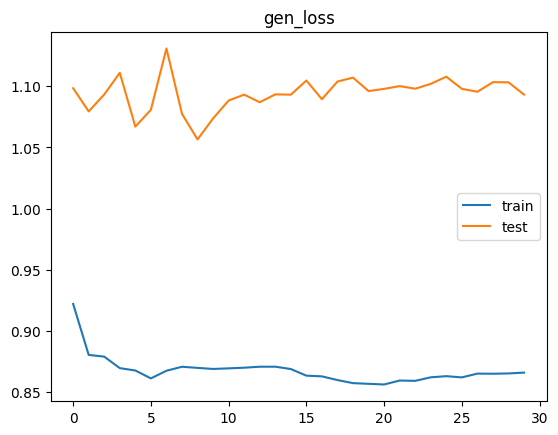

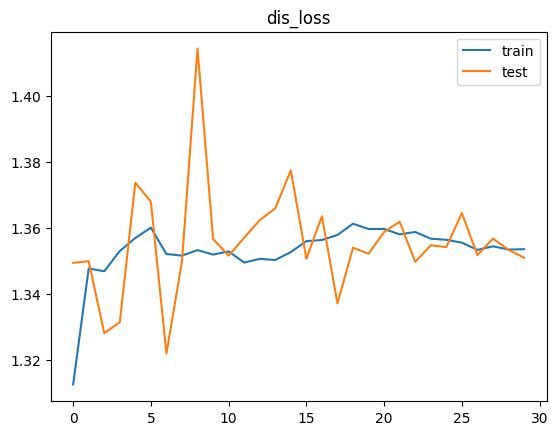

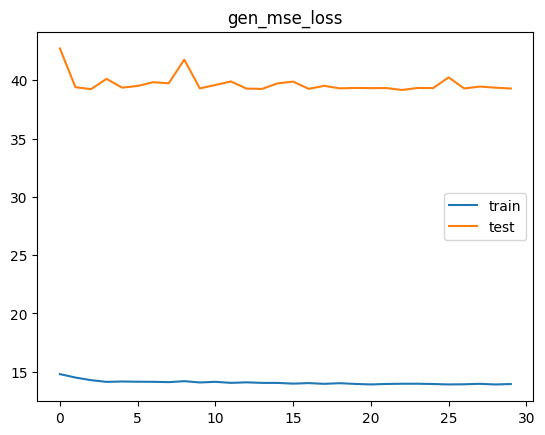

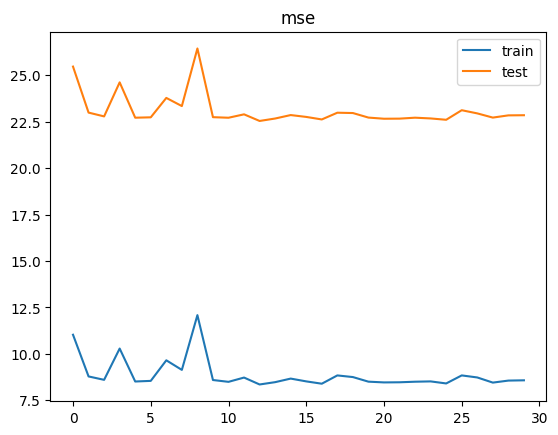

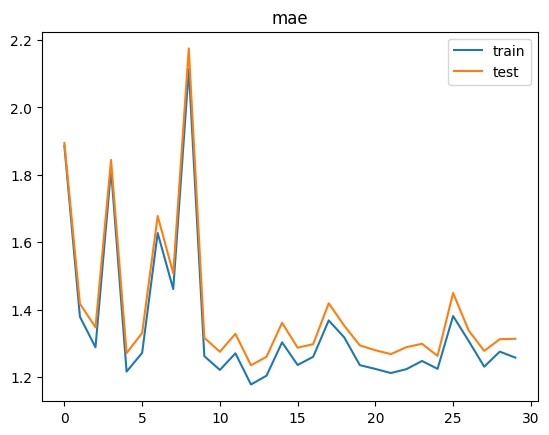

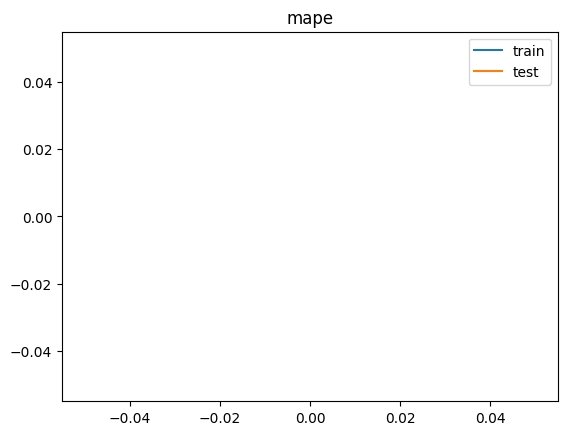

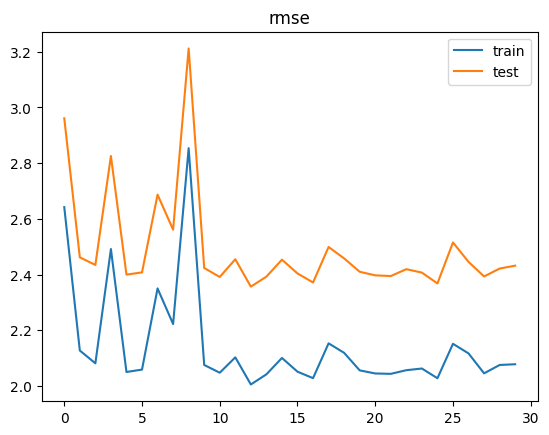

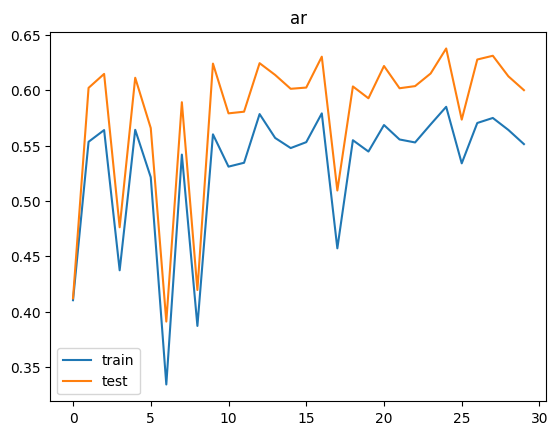

In [30]:
plot_history(history, history_val)

In [31]:
def plot_frame(sequence, target, model):
    sequence, target = data_gen_test[0]
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]

    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()

1/1 [==============================] - 0s 316ms/step


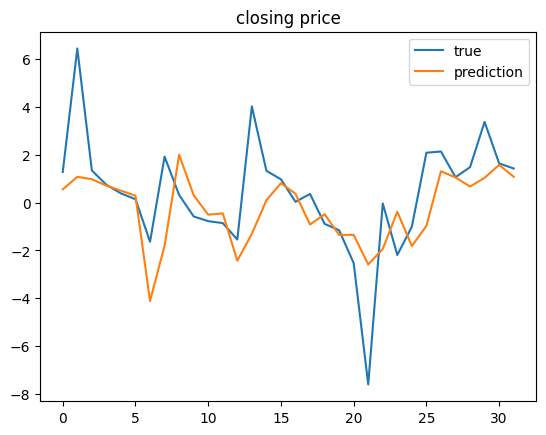

In [32]:
plot_frame(*data_gen_test[0], generator)

In [33]:
def mae_final(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:]-y_pred[:])))
    # ***The absolute is over the whole thing as y_true can be negative
def mape_final(y_true, y_pred):
    return tf.reduce_mean(tf.keras.backend.abs((y_true[:,3]-y_pred[:,3])/y_true[:,3]))
    # ***The absolute is over the whole thing as y_true can be negative
def rmse_final(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true[:]-y_pred[:])))
def ar_final(y_true, y_pred):
    mask = tf.cast(y_pred[1:,3] > y_true[:-1,3],tf.float32)
    return tf.reduce_mean((y_true[1:,3]-y_true[:-1,3])*mask)

In [34]:

def plot_frame_final(sequence, target, model):
    sequence, target = data_gen_test[0]
    y_pred = model.predict(sequence)[...,3]
    y_true = target[...,3]
    rmse_num = rmse_final(y_pred, y_true)
    print(rmse_num)
    mae_num = mae(y_pred, y_true)
    print(mae_num)
    plt.figure()
    plt.title("closing price")
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="prediction")
    plt.legend()
    plt.show()
    return [rmse_num, mae_num]

1/1 [==============================] - 0s 21ms/step


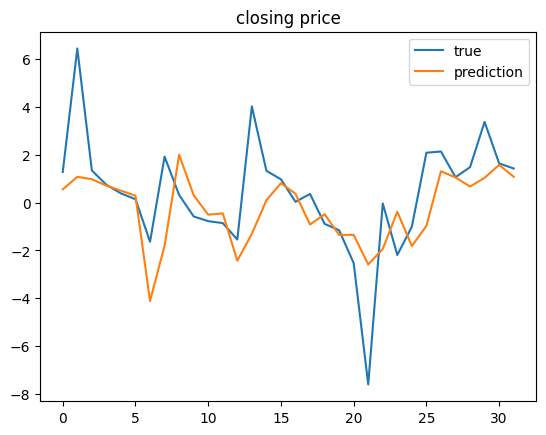

In [35]:
result = plot_frame(*data_gen_test[0], generator)

In [36]:
sequence, target = data_gen_test[0]
y_pred = generator.predict(sequence)[...,3]
y_true = target[...,3]
rmse_num = rmse_final(y_pred, y_true)
print(rmse_num)
mae_num = mae_final(y_pred, y_true)
print(mae_num)

1/1 [==============================] - 0s 22ms/step
tf.Tensor(2.062320152404015, shape=(), dtype=float64)
tf.Tensor(1.3791715622777723, shape=(), dtype=float64)
